In [ ]:
# 패키지 설치
!pip install yfinance --quiet

In [1]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
sns.set()

## 데이터셋 준비

총 16개 ETF에 대한 가격 데이터를 다운받아오도록 하겠습니다. 여기서 사용하게 될 데이터는 전부 주간 단위 데이터입니다. 

In [2]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)
data = data.droplevel(0, axis=1).resample('W').last()

[*********************100%***********************]  9 of 9 completed


In [3]:
# 수익률
rets = data.pct_change().fillna(0)

### 동일 비중 포트폴리오

<Axes: xlabel='Date'>

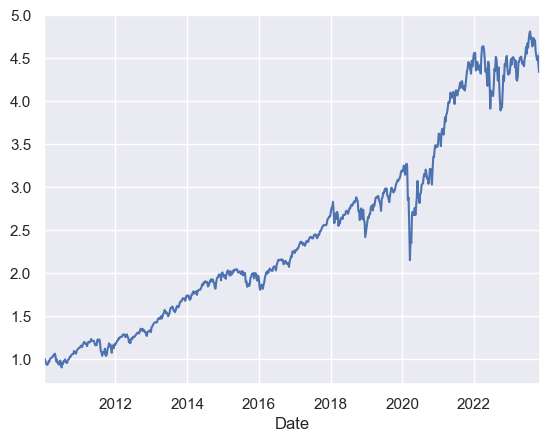

In [4]:
# 동일 비중 포트폴리오 수익률
port_rets = rets.mean(axis=1)

# 백테스팅 수익률
(1 + port_rets).cumprod().plot()

### CVaR 타겟팅 모델

In [5]:
# CVaR 계산 함수
def calculate_CVaR(rets, delta=0.01):
    VaR = rets.quantile(delta) # 수익률 순 중에 하위 1%
    return rets[rets <= VaR].mean() # <<-- CVaR

# 1년 롤링 CVaR 계산
lookback = 52
rolling_CVaR = -port_rets.rolling(lookback).apply(calculate_CVaR).fillna(0)

# 타켓 CVaR
target_CVaR = 0.05

In [6]:
# CVaR 타겟팅 하의 포트폴리오 투자 비중
cvt_weights = (target_CVaR / rolling_CVaR).replace([np.inf, -np.inf], 0).fillna(0)

# 레버리지 사용 불가
cvt_weights[cvt_weights > 1] = 1

# CVaR 타겟팅 포트폴리오 수익률
cvt_rets = (port_rets * cvt_weights.shift()).fillna(0)
cvt_cum_rets = (1 + cvt_rets).cumprod()

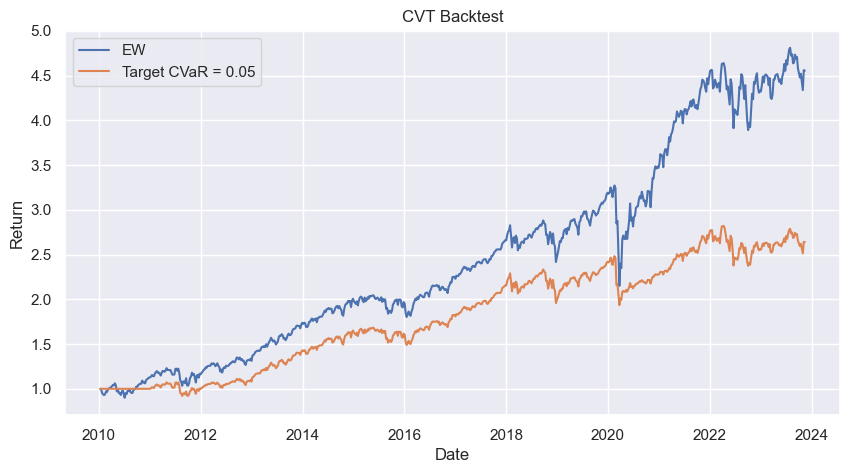

In [7]:
# 백테스팅 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot((1 + port_rets).cumprod(), label='EW')
plt.plot(cvt_cum_rets, label=f'Target CVaR = {target_CVaR}')
plt.title('CVT Backtest')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

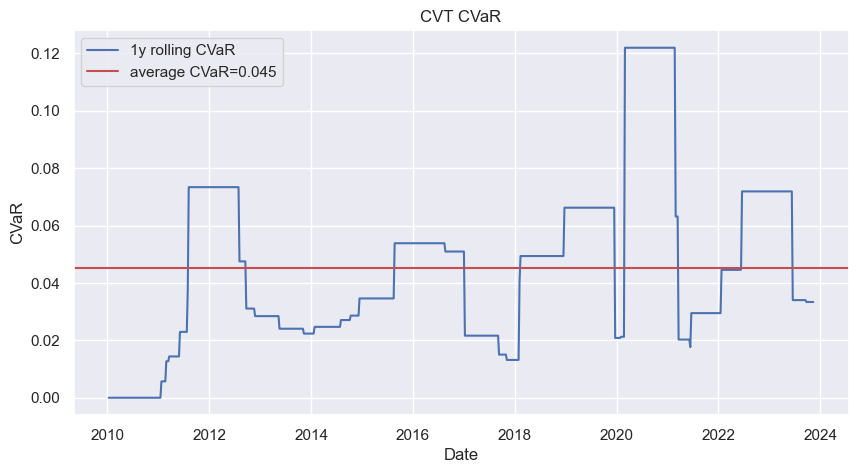

In [8]:
# CVaR 타겟팅 적용시 포트폴리오의 1년 롤링 CVaR 계산
cvt_rolling_CVaR = -cvt_rets.rolling(52).apply(calculate_CVaR).fillna(0)


# 시계열 포트폴리오 CVaR 시각화
plt.figure(figsize=(10, 5))
plt.plot(cvt_rolling_CVaR, label='1y rolling CVaR')
plt.axhline(cvt_rolling_CVaR.mean(), color='r', label=f'average CVaR={np.round(cvt_rolling_CVaR.mean(), 3)}')

plt.title('CVT CVaR')
plt.xlabel('Date')
plt.ylabel('CVaR')
plt.legend()
plt.show()

In [9]:
# 투자 비중 데이터프레임 생성
cvt_weights_df = pd.concat([cvt_weights, 1-cvt_weights], axis=1, join='inner')
cvt_weights_df.columns = ['portfolio', 'cash']

Text(0, 0.5, 'Weights')

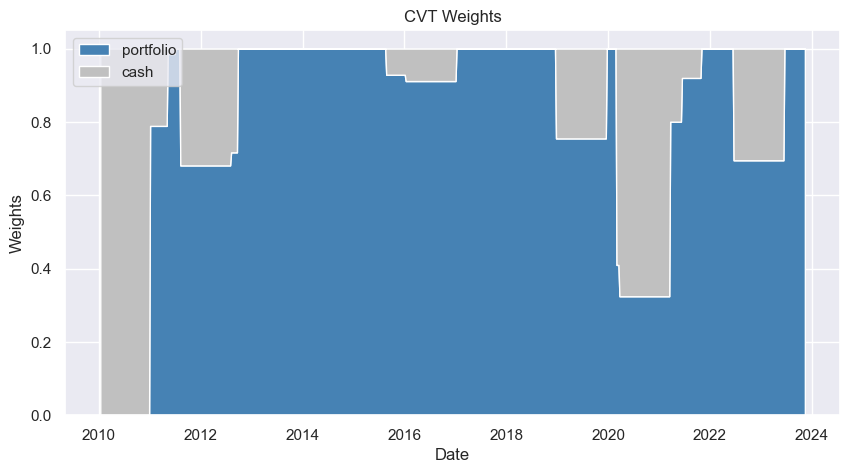

In [10]:
# 가중치 시계열 플랏 시각화
plt.figure(figsize=(10, 5))
plt.stackplot(cvt_weights_df.index, cvt_weights_df.T, labels=cvt_weights_df.columns, colors=['steelblue', 'silver'])
plt.legend(loc='upper left')
plt.title('CVT Weights')
plt.xlabel('Date')
plt.ylabel('Weights')

Copyright 2022. 퀀트대디. All rights reserved.